## good read

https://data.library.virginia.edu/is-r-squared-useless/

https://stats.stackexchange.com/questions/402059/standardised-mean-absolute-error-smae-and-how-to-calculate-it

https://stats.stackexchange.com/questions/131267/how-to-interpret-error-measures/131273#131273

In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
single_copy = pd.read_parquet('single_copy_genes.parquet')
single_copy.head()

,group_id,num_proteins,num_taxa,members,taxa
1277,arCOG00079,112,112,"1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...","[1041930, 1054217, 1070774, 1071085, 1094980, ..."
1279,arCOG00081,166,166,"1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1519,arCOG00354,112,112,"1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1520,arCOG00355,106,106,"1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1561,arCOG00410,168,168,"1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."


In [ ]:
# eggNOG_trees = pd.read_csv('2157_trees.tsv',
#                            sep      ='\t',
#                            header   =None,
#                            usecols  =[1,2,3],
#                            index_col=0,
#                            names    =['group_id', 'fast', 'tree'])
# eggNOG_trees = eggNOG_trees.reindex(index=single_copy.group_id)

In [101]:
group_ids = []
trees     = []
for group_id in single_copy.group_id.values:
    group_ids.append(group_id)
    trees.append(ete3.Tree(f'trees/{group_id}.nwk'))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

# group_ids = []
# trees     = []
# for index, row in eggNOG_trees.iterrows():
#     group_ids.append(index)
#     trees.append(ete3.Tree(row.tree))

# pool          = multiprocessing.Pool(processes = 10)
# dist_matrices = pool.map(get_matrix_from_tree, trees)

# table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

In [47]:
def run_rf(tree_pair):
    tmp_rf = tree_pair[0].robinson_foulds(tree_pair[1])
    return(tmp_rf[0], tmp_rf[0]/tmp_rf[1])

pool      = multiprocessing.Pool(processes=10)
rf_values = pool.map(run_rf, itertools.combinations(trees, 2))

In [489]:
def balance_matrices_no_genes(matrix1, matrix2):
    
    shared_genomes = np.intersect1d(matrix1.index, 
                                    matrix2.index)
    
    matrix1 = matrix1.reindex(index  =shared_genomes, 
                              columns=shared_genomes, 
                              copy   =True)
    matrix2 = matrix2.reindex(index  =shared_genomes, 
                              columns=shared_genomes, 
                              copy   =True)
        
    return(matrix1, matrix2)

def assess_coevolution(matrix1, matrix2, 
                       pearson=False, 
                       geneIDs=True,
                       gene_sep='_'):
    if geneIDs:
        matrix1, taxa1, matrix2, taxa2 = balance_matrices(matrix1, matrix2, gene_sep)
    else:
        matrix1, matrix2 = balance_matrices_no_genes(matrix1.copy(), matrix2.copy())

    condensed1 = squareform(matrix1.values, checks=False)
    condensed2 = squareform(matrix2.values, checks=False)
    
    if pearson:
        return(pearsonr(condensed1,
                        condensed2))
    
    odr_weights = estimate_weights(condensed1, condensed2)
#     odr_weights = (1, 1)
    
    regression = run_odr(condensed1, 
                         condensed2, 
                         *odr_weights)
    
    mean_x = np.mean(condensed1)
    mean_y = np.mean(condensed2)

    mean_pred_x = regression.xplus.mean()
    mean_pred_y = regression.y.mean()
    
    x_SSres = sum(regression.delta**2)
    y_SSres = sum(regression.eps  **2)
    SSres   = x_SSres + y_SSres
#     SSreg = sum(
#         ((regression.xplus - mean_pred_x)**2) + \
#         ((regression.y     - mean_pred_y)**2)
#     )
    SSreg = sum(
        ((regression.xplus - mean_pred_x)**2) + \
        ((regression.y     - mean_pred_y)**2)
    )
    x_SStot = sum(
        (condensed1 - mean_x)**2
    )
    y_SStot = sum(
        (condensed2 - mean_y)**2
    )
    SStot = x_SStot + y_SStot
    

    r2 = 1 - SSres/SStot
#     r2 = SSreg/SStot

#     x_mse = np.mean(regression.delta**2)
#     y_mse = np.mean(regression.eps  **2)
#     mse   = x_mse + y_mse
    mse   = (x_SSres/x_SStot) + (y_SSres/y_SStot)

    return(regression, r2, mse)

In [395]:
matrix1, matrix2 = balance_matrices_no_genes(dist_matrices[0].copy(), dist_matrices[1].copy())

condensed1 = squareform(matrix1.values, checks=False)
condensed2 = squareform(matrix2.values, checks=False)

# odr_weights = estimate_weights(condensed1, condensed2)
odr_weights = (1, 1)

regression = run_odr(condensed1, 
                     condensed2, 
                     *odr_weights)

mean_x = np.mean(condensed1)
mean_y = np.mean(condensed2)

mean_pred_x = regression.xplus.mean()
mean_pred_y = regression.y.mean()

mse = np.mean((regression.delta**2) + (regression.eps**2))

SSres = sum((regression.delta**2) + (regression.eps**2))
SSreg = sum(
    ((regression.xplus - mean_pred_x)**2) + \
    ((regression.y     - mean_pred_y)**2)
)
SStot = sum(
    ((condensed1 - mean_x)**2) + \
    ((condensed2 - mean_y)**2)
)

1 - SSres/SStot, SSreg/SStot

(0.9323014957266564, 0.9379226284947174)

In [490]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    return(assess_coevolution(m1, m2, gene_sep='.', geneIDs=False)[1:])

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[1].copy()
run_coevol((matrix1, matrix2))

(0.8713248922984702, 0.5122731882170397)

In [491]:
pool   = multiprocessing.Pool(processes=10)
odr_r2 = np.array(pool.map(run_coevol, itertools.combinations(dist_matrices, 2)))

In [492]:
group1, group2 = [], []
for n, m in itertools.combinations(group_ids, 2):
    group1.append(n)
    group2.append(m)

In [493]:
odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared', 'mse'],
                      data   =zip(group1,
                                  group2,
                                  odr_r2[:, 0],
                                  odr_r2[:, 1]))
# odr_df.to_parquet('odr_regression_Rsquared.parquet')

In [50]:
rf_edges = pd.DataFrame(columns=['group1', 'group2', 'rf', 'rf_norm'],
                        data   =zip(group1,
                                    group2,
                                    rf_values,
                                    rf_values_norm))
# rf_edges.to_parquet('rf_distances.parquet')

In [367]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

pool               = multiprocessing.Pool(processes=10)
braycurtis_indices = pool.map(get_braycurtis, 
                              itertools.combinations(single_copy.iterrows(), 2))

In [456]:
braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                             data   =braycurtis_indices)
# braycurtis_df.to_parquet('braycurtis_indices.parquet')

In [494]:
# odr_df['jaccard_product']   = odr_df.Rsquared * jaccard_df.jaccard
odr_df['Rsquared_corrected']= odr_df.Rsquared * braycurtis_df.braycurtis

In [279]:
braycurtis_df.head()

,group1,group2,braycurtis
0,arCOG00079,arCOG00081,0.798561
1,arCOG00079,arCOG00354,0.857143
2,arCOG00079,arCOG00355,0.807339
3,arCOG00079,arCOG00410,0.800000
4,arCOG00079,arCOG00487,0.800000


In [77]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)
# rf_matrix  = pd.read_csv('rf_distances.csv',       index_col=0)
# rf_matrix  = rf_matrix.reindex(index  =group_ids,
#                                columns=group_ids)

triu_indices           = np.triu_indices_from(geo_matrix, k=1)
geo_edges              = pd.DataFrame()
geo_edges['group1']    = geo_matrix.index[ triu_indices[0]]
geo_edges['group2']    = geo_matrix.index[ triu_indices[1]]
geo_edges['geodesic' ] = geo_matrix.values[triu_indices]

# triu_indices       = np.triu_indices_from(rf_matrix, k=1)
# rf_edges2           = pd.DataFrame()
# rf_edges2['group1'] = rf_matrix.index[ triu_indices[0]]
# rf_edges2['group2'] = rf_matrix.index[ triu_indices[1]]
# rf_edges2['rf' ]    = rf_matrix.values[triu_indices]

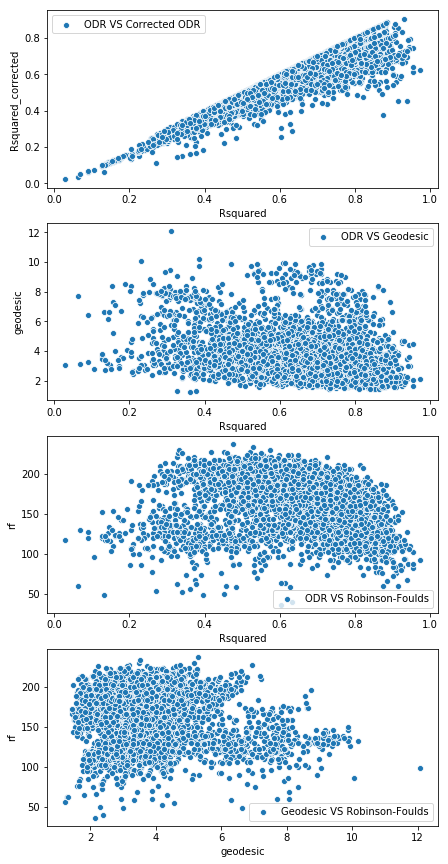

In [280]:
fig, axs = plt.subplots(nrows=4, figsize=(7, 15))

sns.scatterplot(odr_df.Rsquared,
                odr_df.Rsquared_corrected,
                ax   =axs[0],
                label='ODR VS Corrected ODR')

sns.scatterplot(odr_df.Rsquared,
                geo_edges.geodesic,
                ax   =axs[1],
                label='ODR VS Geodesic')

sns.scatterplot(odr_df.Rsquared,
                rf_edges.rf,
                ax   =axs[2],
                label='ODR VS Robinson-Foulds')

sns.scatterplot(geo_edges.geodesic,
                rf_edges.rf,
                ax   =axs[3],
                label='Geodesic VS Robinson-Foulds');

In [495]:
string = pd.read_parquet('duplications/few_duplications-string.parquet')

string = string.query('group1 in @single_copy.group_id & '
                      'group2 in @single_copy.group_id').copy()

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

strongly_related = string.query('combined_score >= 900')
weakly_related   = string.query('combined_score <= 200')

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
geo_edges['group_pair'] = geo_edges[['group1', 'group2']].agg(frozenset, axis=1)
rf_edges['group_pair'] = rf_edges[['group1', 'group2']].agg(frozenset, axis=1)
rf_edges2['group_pair'] = rf_edges2[['group1', 'group2']].agg(frozenset, axis=1)

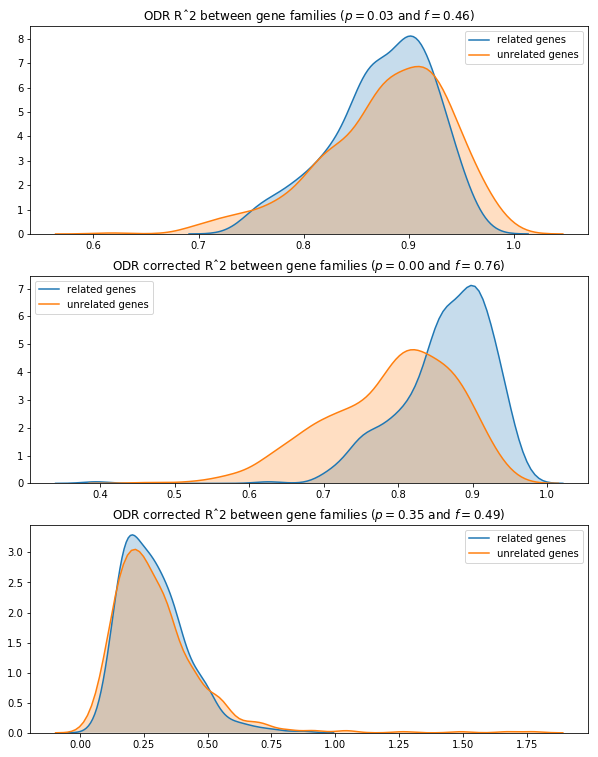

In [496]:
data_columns = ['Rsquared', 'Rsquared_corrected', 'mse']

fig, axs = plt.subplots(nrows=3, figsize=(10,13))
for ax, column in zip(axs, data_columns):
    
    strong_odr = odr_df.query('group_pair in @strongly_related.group_pair')[column].values
    weak_odr   = odr_df.query('group_pair in @weakly_related.group_pair'  )[column].values

    hypothesis = mannwhitneyu(weak_odr,
                              strong_odr)
    
    if column == 'mse':
        effect_size = cles(strong_odr, weak_odr)
    else:
        effect_size = cles(weak_odr, strong_odr)

    sns.kdeplot(strong_odr, shade=True, label='related genes',   ax=ax)
    sns.kdeplot(weak_odr,   shade=True, label='unrelated genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

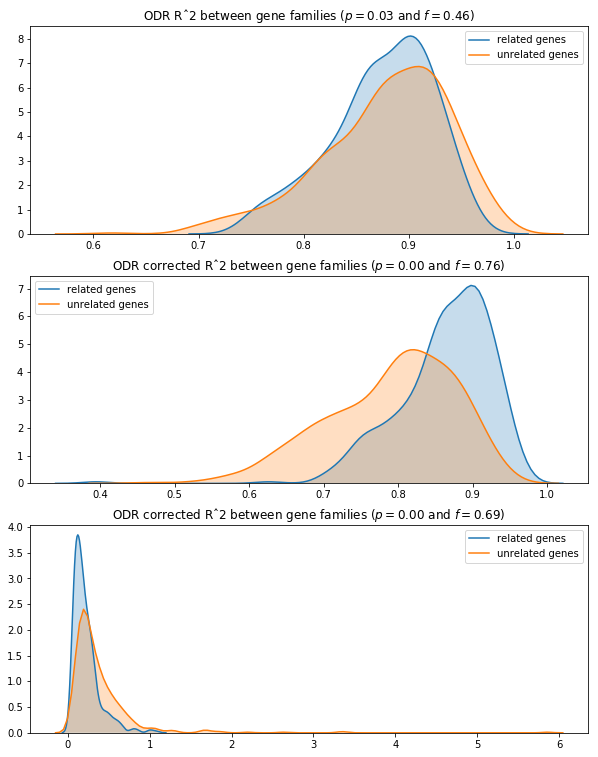

In [393]:
data_columns = ['Rsquared', 'Rsquared_corrected', 'mse']

fig, axs = plt.subplots(nrows=3, figsize=(10,13))
for ax, column in zip(axs, data_columns):
    
    strong_odr = odr_df.query('group_pair in @strongly_related.group_pair')[column].values
    weak_odr   = odr_df.query('group_pair in @weakly_related.group_pair'  )[column].values

    hypothesis = mannwhitneyu(weak_odr,
                              strong_odr)
    
    if column == 'mse':
        effect_size = cles(strong_odr, weak_odr)
    else:
        effect_size = cles(weak_odr, strong_odr)

    sns.kdeplot(strong_odr, shade=True, label='related genes',   ax=ax)
    sns.kdeplot(weak_odr,   shade=True, label='unrelated genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

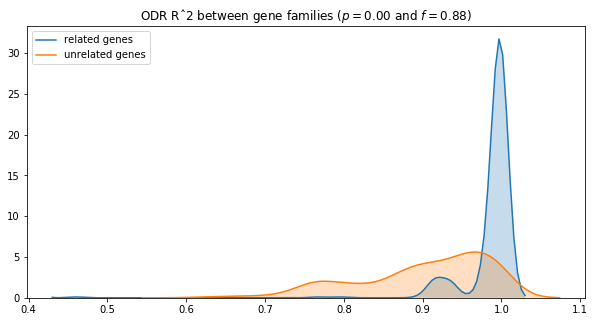

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
    
strong_odr = braycurtis_df.query('group_pair in @strongly_related.group_pair')['braycurtis'].values
weak_odr   = braycurtis_df.query('group_pair in @weakly_related.group_pair'  )['braycurtis'].values

hypothesis = mannwhitneyu(weak_odr,
                          strong_odr)
effect_size = cles(weak_odr, strong_odr)

sns.kdeplot(strong_odr, bw=0.01, shade=True, label='related genes',   ax=ax)
sns.kdeplot(weak_odr,   shade=True, label='unrelated genes', ax=ax)

ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

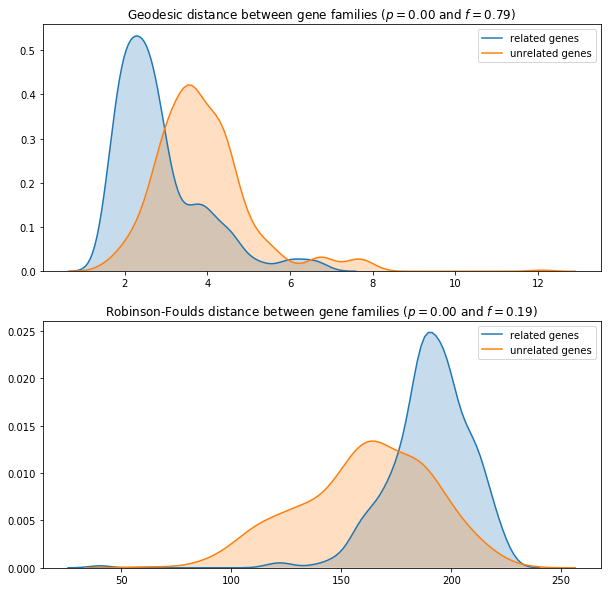

In [91]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_edges.query('group_pair in @strongly_related.group_pair'    ).geodesic.values
not_neighors_geo = geo_edges.query('group_pair in @weakly_related.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label='related genes',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label='unrelated genes', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_edges.query('group_pair in @strongly_related.group_pair'    ).rf.values
not_neighors_rf = rf_edges.query('group_pair in @weakly_related.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='related genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label='unrelated genes', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

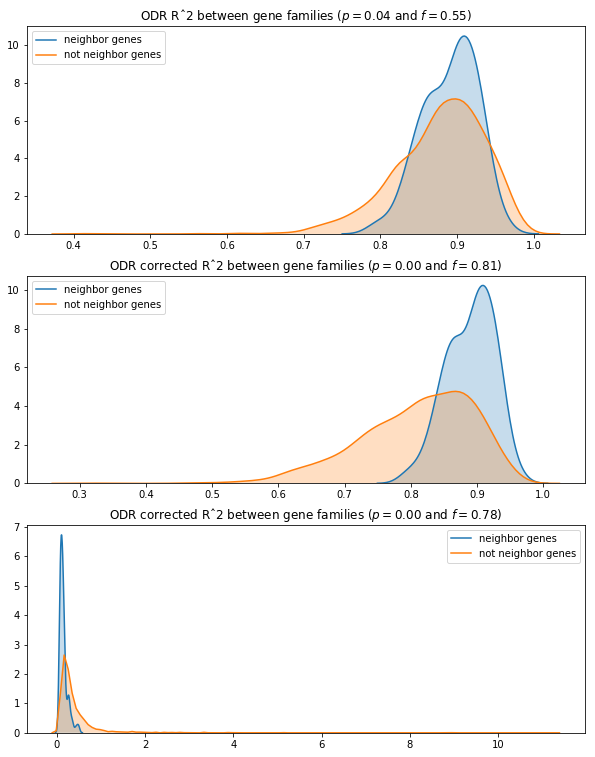

In [119]:
fig, axs = plt.subplots(nrows=3, figsize=(10,13))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    
    if column == 'mse':
        effect_size = cles(neighors_odr, not_neighors_odr)
    else:
        effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label='neighbor genes',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label='not neighbor genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

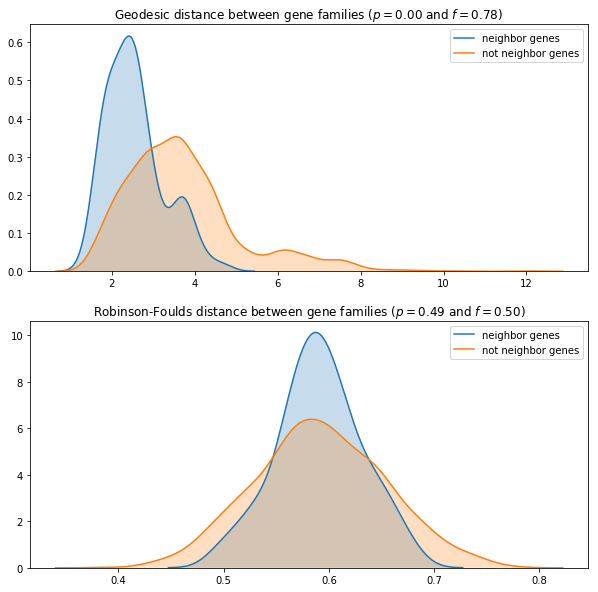

In [80]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_edges.query('group_pair in @neighors.group_pair'    ).geodesic.values
not_neighors_geo = geo_edges.query('group_pair in @not_neighors.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label='neighbor genes',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label='not neighbor genes', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_edges.query('group_pair in @neighors.group_pair'    ).rf_norm.values
not_neighors_rf = rf_edges.query('group_pair in @not_neighors.group_pair').rf_norm.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='neighbor genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label='not neighbor genes', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

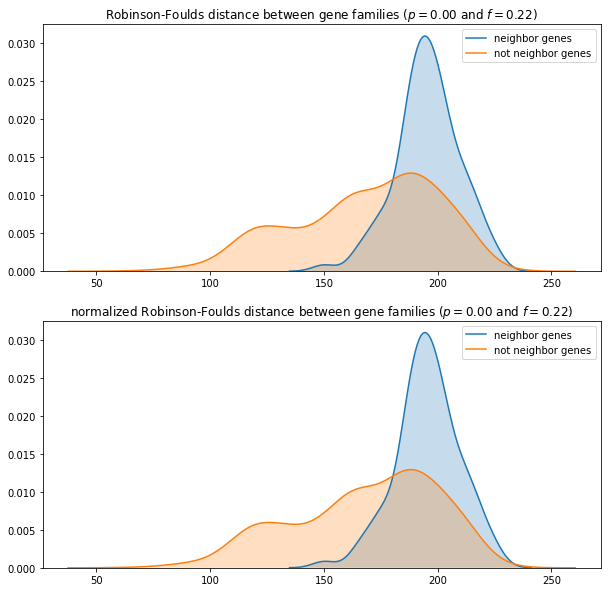

In [76]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_rf     = rf_edges.query('group_pair in @neighors.group_pair'    ).rf.values
not_neighors_rf = rf_edges.query('group_pair in @not_neighors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='neighbor genes',     ax=axs[0])
sns.kdeplot(not_neighors_rf, shade=True, label='not neighbor genes', ax=axs[0])
axs[0].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_edges2.query('group_pair in @neighors.group_pair'    ).rf.values
not_neighors_rf = rf_edges2.query('group_pair in @not_neighors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label='neighbor genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label='not neighbor genes', ax=axs[1])
axs[1].set_title(f'normalized Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');